In [24]:
import requests
import os
import time
from pathlib import Path
import pandas as pd, pyarrow as pa
import glob 
import matplotlib.pyplot as plt
import duckdb
import numpy as np

# Tarefa 1: Setup e Consolidação dos Dados
1. Download automatizado:

    * Códigos para baixar arquivos mensais de 2023 e 2024 (meta: 24 meses, mínimo: 12
        meses)

    * Encontrar os dados e o padrão da URL em:
        `https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page`

    * Focar apenas nos Yellow Taxi Trip Records

    * Verificar integridade dos arquivos e tratar erros

In [3]:
# Padrão:
# ano em yyyy
# mes em mm
# `https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{ano}-{mes}.parquet`

def baixar_arquivo_com_pathlib(url, pasta_destino):
    pasta = Path(pasta_destino)
    # Garante que a pasta de destino exista
    pasta.mkdir(parents=True, exist_ok=True)

    nome_arquivo = url.split('/')[-1]
    caminho_local = pasta / nome_arquivo 

    print(f"Baixando '{nome_arquivo}' de '{url}'...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(caminho_local, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"Download concluído com sucesso! Arquivo salvo em: {caminho_local}")
        return caminho_local
    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar o arquivo: {e}")
        return None

url_do_arquivo = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
pasta_para_salvar = "data"

meses = [f"{i:02d}" for i in range(1, 13)]
anos = ['2023']

# PODE QUEBRAR COM OS DADOS DE 2025 QUE NÃO TEM OS DADOS DE TODOS OS MESES MESES 
for ano in anos:
    for mes in meses:
        
        baixar_arquivo_com_pathlib(
            f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{ano}-{mes}.parquet", 
            pasta_para_salvar
        )

# VERIFICAR A INTEGRIDADE DOS ARQUIVOS 

#print(f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{ano}-{mes}.parquet")


Baixando 'yellow_tripdata_2023-01.parquet' de 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'...
Download concluído com sucesso! Arquivo salvo em: data\yellow_tripdata_2023-01.parquet
Baixando 'yellow_tripdata_2023-02.parquet' de 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'...
Download concluído com sucesso! Arquivo salvo em: data\yellow_tripdata_2023-02.parquet
Baixando 'yellow_tripdata_2023-03.parquet' de 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet'...
Download concluído com sucesso! Arquivo salvo em: data\yellow_tripdata_2023-03.parquet
Baixando 'yellow_tripdata_2023-04.parquet' de 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet'...
Download concluído com sucesso! Arquivo salvo em: data\yellow_tripdata_2023-04.parquet
Baixando 'yellow_tripdata_2023-05.parquet' de 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-05.parquet'.

## 2. Análise de schema:
* Examine estrutura dos arquivos Parquet
* Identifique e cuide de mudanças de schema entre diferentes meses

In [4]:
#Verificando os arquivos

# Ler arquivo parquet

meses = [f"{i:02d}" for i in range(1, 13)]
anos = ['2023','2024']

base_path = "data"  # pasta onde estão os arquivos
schemas = {}

for ano in anos:
    for mes in meses:
        file_name = f"yellow_tripdata_{ano}-{mes}.parquet"
        file_path = os.path.join(base_path, file_name)

        if os.path.exists(file_path):
            try:
                # Lê apenas o schema sem carregar tudo na memória
                df = pd.read_parquet(file_path, engine="fastparquet")

                # Guarda colunas e tipos em dicionário
                schemas[file_name] = {col: str(dtype) for col, dtype in df.dtypes.items()}
            except Exception as e:
                print(f"Erro ao ler {file_name}: {e}")

# Agora vamos comparar os schemas
all_columns = set()
for schema in schemas.values():
    all_columns.update(schema.keys())

print("\n=== Diferenças detectadas ===\n")
for file, schema in schemas.items():
    missing = all_columns - set(schema.keys())
    extra = set(schema.keys()) - all_columns
    if missing or extra:
        print(f"{file}:")
        if missing:
            print(f"  - Faltando colunas: {missing}")
        if extra:
            print(f"  - Colunas extras: {extra}")

# Comparar tipos coluna a coluna
print("\n=== Divergências de tipos ===\n")
for col in all_columns:
    tipos = {}
    for file, schema in schemas.items():
        if col in schema:
            tipos[file] = schema[col]
    if len(set(tipos.values())) > 1:
        print(f"Coluna '{col}' com tipos diferentes:")
        for file, tipo in tipos.items():
            print(f"  {file}: {tipo}")


=== Diferenças detectadas ===

yellow_tripdata_2023-01.parquet:
  - Faltando colunas: {'Airport_fee'}
yellow_tripdata_2023-02.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-03.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-04.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-05.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-06.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-07.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-08.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-09.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-10.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-11.parquet:
  - Faltando colunas: {'airport_fee'}
yellow_tripdata_2023-12.parquet:
  - Faltando colunas: {'airport_fee'}

=== Divergências de tipos ===

Coluna 'VendorID' com tipos diferentes:
  yellow_tripdata_2023-01.parquet: int64
  y

In [5]:
# Correção destes problemas

files = glob.glob("data/yellow_tripdata_*.parquet")

# Colunas padrão (ajustadas para minúsculas)
colunas_padrao = [
    "vendorid", "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "passenger_count", "trip_distance", "ratecodeid", "store_and_fwd_flag",
    "pulocationid", "dolocationid", "payment_type", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge",
    "total_amount", "congestion_surcharge", "airport_fee"
]

# Tipos alvo
dtype_fix = {
    "vendorid": "Int32",
    "pulocationid": "Int32",
    "dolocationid": "Int32",
    "payment_type": "Int32",
    "passenger_count": "Int32",
    "trip_distance": "float64",
    "fare_amount": "float64",
    "total_amount": "float64",
    "tpep_pickup_datetime": "datetime64[ns]",
    "tpep_dropoff_datetime": "datetime64[ns]",
}

dfs = []

for f in files:
    df = pd.read_parquet(f, engine="pyarrow")
    
    # padronizar nomes
    df.columns = df.columns.str.lower()
    
    # garantir colunas padrão (faltantes = NaN)
    df = df.reindex(columns=colunas_padrao)
    
    # aplicar dtypes
    for col, tipo in dtype_fix.items():
        if col in df.columns:
            try:
                df[col] = df[col].astype(tipo)
            except Exception:
                # fallback: se não converter, deixa como está
                df[col] = pd.to_numeric(df[col], errors="coerce") if "float" in tipo or "int" in tipo else df[col]
    
    dfs.append(df)

# Concatenar
df_final = pd.concat(dfs, ignore_index=True)

# Salvar unificado
#df_final.to_parquet("yellow_tripdata_all.parquet", engine="pyarrow", compression="snappy")

df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38310226 entries, 0 to 38310225
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   vendorid               Int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        Int32         
 4   trip_distance          float64       
 5   ratecodeid             float64       
 6   store_and_fwd_flag     object        
 7   pulocationid           Int32         
 8   dolocationid           Int32         
 9   payment_type           Int32         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

## 3. Limpeza de dados
* Remover registros com duração de viagem negativa ou zero
* Filtrar coordenadas inválidas (fora dos ranges de latitude/longitude)
* Eliminar valores negativos em campos monetários
* Remover registros com passenger_count = 0
* Validar datas dentro do período esperado

In [6]:
print('\n',"Antes remover duração <= 0: ", len(df_final))
# 1. Remover duração <= 0
df_final = df_final[(df_final["tpep_dropoff_datetime"] > df_final["tpep_pickup_datetime"])]

print('\n',"Depois remover duração <= 0: ", len(df_final))

print('\n','Antes de remover passageiros <= 0: ',len(df_final))
# 2. Remover passenger_count = 0
df_final = df_final[df_final["passenger_count"] > 0]

print('\n','Depois de remover passageiros <= 0: ',len(df_final))

print('\n','Antes de eliminar valores negativos em campos monetarios: ',len(df_final))
# 3. Eliminar valores negativos em campos monetários
df_final = df_final[df_final["fare_amount"] >= 0]
print('\n','Depois de eliminar valores negativos em campos monetarios: ',len(df_final))


#print("\n ","Antes de filtrar codernadas validas:", len(df_final))

# Filtro: coordenadas válidas
# Onde está as variaveis de coordenada ???

#print("\n","Depois de filtrar codernadas validas::", len(df_final))

print("\n","Antes de Validar datas dentro do período esperado: ", len(df_final))

# Definir limites de datas esperadas
data_min = "2023-01-01"
data_max = "2024-12-31"

df_final = df_final[
    (df_final["tpep_pickup_datetime"].between(data_min, data_max)) &
    (df_final["tpep_dropoff_datetime"].between(data_min, data_max))
]

print("\n","Depois de Validar datas dentro do período esperado: ", len(df_final))


 Antes remover duração <= 0:  38310226

 Depois remover duração <= 0:  38294657

 Antes de remover passageiros <= 0:  38294657

 Depois de remover passageiros <= 0:  36405739

 Antes de eliminar valores negativos em campos monetarios:  36405739

 Depois de eliminar valores negativos em campos monetarios:  36031004

 Antes de Validar datas dentro do período esperado:  36031004

 Depois de Validar datas dentro do período esperado:  36030907


## 4. Consolidação:
* Concatene arquivos em dataset único
* Exporte em: CSV, Parquet Snappy, Parquet ZSTD
* Registre os tamanhos de arquivo de cada formato 

In [7]:
# Definir pasta de saída
output_dir = "data/cleaned"
os.makedirs(output_dir, exist_ok=True)

# Arquivos de saída
csv_path = os.path.join(output_dir, "yellow_tripdata_clean.csv")
parquet_snappy_path = os.path.join(output_dir, "yellow_tripdata_clean_snappy.parquet")
parquet_zstd_path = os.path.join(output_dir, "yellow_tripdata_clean_zstd.parquet")

# 1. Exportar CSV (sem index)
df_final.to_csv(csv_path, index=False)

# 2. Exportar Parquet Snappy
df_final.to_parquet(parquet_snappy_path, engine="pyarrow", compression="snappy", index=False)

# 3. Exportar Parquet ZSTD
df_final.to_parquet(parquet_zstd_path, engine="pyarrow", compression="zstd", index=False)

# Função para mostrar tamanho do arquivo em MB
def get_size(path):
    return os.path.getsize(path) / (1024 * 1024)

# Tarefa 2: Benchmark de Performance
1. Medidas de armazenamento::

    * Compare tamanhos: CSV vs Parquet Snappy vs Parquet ZSTD

    * Calcule taxas de compressão relativas

    * Gráfico de barras com diferenças percentuais

In [19]:
def get_size(path):
    return os.path.getsize(path) / (1024 * 1024)

csv_path = "data/cleaned/yellow_tripdata_clean.csv"
parquet_snappy_path = "data/cleaned/yellow_tripdata_clean_snappy.parquet"
parquet_zstd_path = "data/cleaned/yellow_tripdata_clean_zstd.parquet"

# === Ler apenas uma amostra ===
n_rows = 5_000_000

start = time.time()
pd.read_csv(csv_path, nrows=n_rows)
csv_read_time = time.time() - start

start = time.time()
pd.read_parquet(parquet_snappy_path, engine="pyarrow")
snappy_read_time = time.time() - start

start = time.time()
pd.read_parquet(parquet_zstd_path, engine="pyarrow")
zstd_read_time = time.time() - start

# === Calcular tamanhos ===
csv_size = get_size(csv_path)
snappy_size = get_size(parquet_snappy_path)
zstd_size = get_size(parquet_zstd_path)

# === Calcular taxas de compressão ===
snappy_ratio = (snappy_size / csv_size) * 100
zstd_ratio = (zstd_size / csv_size) * 100

snappy_reduction = 100 - snappy_ratio
zstd_reduction = 100 - zstd_ratio

# === Exibir resultados ===
print("\n=== Tamanhos dos arquivos ===")
print(f"CSV: {csv_size:.2f} MB")
print(f"Parquet (Snappy): {snappy_size:.2f} MB")
print(f"Parquet (ZSTD): {zstd_size:.2f} MB")

print("\n=== Taxas de compressão relativas ===")
print(f"Snappy: {snappy_ratio:.2f}% do tamanho original ({snappy_reduction:.2f}% menor)")
print(f"ZSTD:   {zstd_ratio:.2f}% do tamanho original ({zstd_reduction:.2f}% menor)")

print("\n=== Tempo de leitura (segundos) ===")
print(f"CSV (amostra {n_rows:,}): {csv_read_time:.3f}")
print(f"Parquet (Snappy): {snappy_read_time:.3f}")
print(f"Parquet (ZSTD): {zstd_read_time:.3f}")



=== Tamanhos dos arquivos ===
CSV: 3584.70 MB
Parquet (Snappy): 727.19 MB
Parquet (ZSTD): 593.88 MB

=== Taxas de compressão relativas ===
Snappy: 20.29% do tamanho original (79.71% menor)
ZSTD:   16.57% do tamanho original (83.43% menor)

=== Tempo de leitura (segundos) ===
CSV (amostra 5,000,000): 7.636
Parquet (Snappy): 2.616
Parquet (ZSTD): 2.436


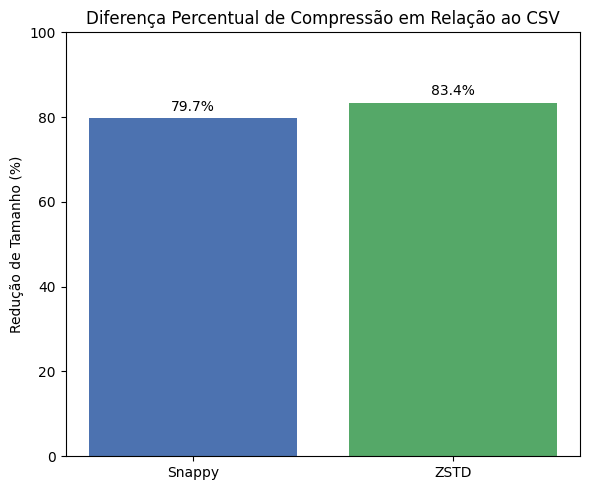

In [22]:
# === Gráfico: diferença percentual de compressão ===
formats = ["Snappy", "ZSTD"]
reductions = [snappy_reduction, zstd_reduction]

plt.figure(figsize=(6, 5))
bars = plt.bar(formats, reductions, color=["#4C72B0", "#55A868"])

plt.title("Diferença Percentual de Compressão em Relação ao CSV")
plt.ylabel("Redução de Tamanho (%)")
plt.ylim(0, 100)

# Mostrar valores no topo das barras
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 2. Benchmark de carregamento:
* Meça tempo de leitura:
    * CSV → Pandas
    * CSV → DuckDB
    * Parquet → Pandas
    * Parquet → DuckDB
* Use time.time() com pelo menos 5 execuções, tire a média e desvio padrão

In [ ]:
# === Função para medir tempos médios com desvio padrão ===
def measure_time_duckdb(query_func, n_runs=5):
    times = []
    for _ in range(n_runs):
        start = time.time()
        query_func()
        times.append(time.time() - start)
    mean_time = np.mean(times)
    std_time = np.std(times)
    return mean_time, std_time

# === Número de linhas para limitar leitura do CSV gigante ===
limit_rows = 1_000_000

# === Definir funções de leitura com limitação ===
def read_csv_duckdb():
    duckdb.query(f"SELECT * FROM read_csv_auto('{csv_path}') LIMIT {limit_rows}").fetchall()

def read_parquet_snappy_duckdb():
    duckdb.query(f"SELECT * FROM read_parquet('{parquet_snappy_path}') LIMIT {limit_rows}").fetchall()

def read_parquet_zstd_duckdb():
    duckdb.query(f"SELECT * FROM read_parquet('{parquet_zstd_path}') LIMIT {limit_rows}").fetchall()

# === Executar medições ===
csv_mean, csv_std = measure_time_duckdb(read_csv_duckdb)
snappy_mean, snappy_std = measure_time_duckdb(read_parquet_snappy_duckdb)
zstd_mean, zstd_std = measure_time_duckdb(read_parquet_zstd_duckdb)

# === Exibir resultados ===
print(f"\n=== Tempo de leitura com DuckDB (amostra {limit_rows:,} linhas) ===")
print(f"CSV (5 execuções): {csv_mean:.3f} ± {csv_std:.3f} s")
print(f"Parquet (Snappy, 5 execuções): {snappy_mean:.3f} ± {snappy_std:.3f} s")
print(f"Parquet (ZSTD, 5 execuções): {zstd_mean:.3f} ± {zstd_std:.3f} s")


=== Tempo de leitura com DuckDB (amostra 1,000,000 linhas) ===
CSV (5 execuções): 2.657 ± 0.013 s
Parquet (Snappy, 5 execuções): 2.002 ± 0.026 s
Parquet (ZSTD, 5 execuções): 1.994 ± 0.007 s


In [32]:
# === Função para medir tempos médios com desvio padrão ===
def measure_time_pandas(query_func, n_runs=5):
    times = []
    for _ in range(n_runs):
        start = time.time()
        query_func()
        times.append(time.time() - start)
    mean_time = np.mean(times)
    std_time = np.std(times)
    return mean_time, std_time

# === Número de linhas para limitar leitura do CSV gigante ===
limit_rows = 1_000_000

# === Definir funções de leitura para Pandas ===
def read_csv_pandas():
    pd.read_csv(csv_path, nrows=limit_rows)

def read_parquet_snappy_pandas():
    pd.read_parquet(parquet_snappy_path, engine="pyarrow")

def read_parquet_zstd_pandas():
    pd.read_parquet(parquet_zstd_path, engine="pyarrow")

# === Executar medições ===
csv_mean, csv_std = measure_time_pandas(read_csv_pandas)
snappy_mean, snappy_std = measure_time_pandas(read_parquet_snappy_pandas)
zstd_mean, zstd_std = measure_time_pandas(read_parquet_zstd_pandas)

# === Exibir resultados ===
print(f"\n=== Tempo de leitura com Pandas (amostra {limit_rows:,} linhas) ===")
print(f"CSV (5 execuções): {csv_mean:.3f} ± {csv_std:.3f} s")
print(f"Parquet (Snappy, 5 execuções): {snappy_mean:.3f} ± {snappy_std:.3f} s")
print(f"Parquet (ZSTD, 5 execuções): {zstd_mean:.3f} ± {zstd_std:.3f} s")


=== Tempo de leitura com Pandas (amostra 1,000,000 linhas) ===
CSV (5 execuções): 1.388 ± 0.035 s
Parquet (Snappy, 5 execuções): 2.567 ± 0.071 s
Parquet (ZSTD, 5 execuções): 2.551 ± 0.068 s


## 3. Benchmark de consultas :
* Receita por zona: TOP 10 zonas de pickup por receita total média
* Padrões temporais: Agregação por mês/semana (COUNT viagens, SUM receita, AVG distância)
* Horário de pico: Ranking de horários mais movimentados usando window functions (RANK/ROW_NUMBER)
* Análise de gorjeta: Taxa de gorjeta média por borough usando CASE WHEN para categorizar
* Viagens longas vs curtas: Comparativo usando CASE para categorizar distâncias

## 4. Para cada consulta escolhida, você deve:
* Implementar em SQL (DuckDB) e validar os resultados inspecionando os dados
* Implementar equivalente em Pandas e verificar se os resultados são consistentes
* Anotar quais consultas falharam no Pandas (memória, tempo, erro)
* Medir tempo de execução rodando cada consulta 5 vezes em cada ferramenta
* Registrar apenas consultas que executaram com sucesso para comparação de performance